In [2]:
"""
Asymmetric Penalty Binary Cross-Entropy Loss

A novel loss function that combines label smoothing with asymmetric penalties:
- Minimum at smoothed label (not at hard labels)
- Steeper penalty toward opposing class
- Gentler penalty toward actual class

Mathematical Foundation:
1. Standard BCE: -[y*log(p) + (1-y)*log(1-p)]
2. Label Smoothing: Replace y with y_smooth = y*(1-ε) + (1-y)*ε
3. Asymmetric Penalty: Add directional penalties around the smoothed optimum
4. Focal-loss
5. Binary Active-Negative Loss (ANL-CE)
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy

In [3]:

def standard_binary_crossentropy(y_true, y_pred):
    """Standard Binary Cross-Entropy Loss"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def label_smoothing_binary_crossentropy(y_true, y_pred, label_smoothing=0.1):
    """Binary Cross-Entropy with Standard Label Smoothing"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Apply label smoothing: y=1 → 1-ε, y=0 → ε
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing

    return -tf.reduce_mean(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

def asymmetric_penalty_binary_crossentropy(y_true, y_pred, label_smoothing=0.1,
                                           asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """
    Asymmetric Penalty Binary Cross-Entropy Loss with separate asymmetry for each class

    Features:
    - Minimum at smoothed label: p = 1-ε (true=1), p = ε (true=0)
    - Steeper penalty toward opposing class
    - Gentler penalty toward actual class
    - Separate asymmetry control for positive and negative classes

    Args:
        y_true: Ground truth binary labels
        y_pred: Predicted probabilities
        label_smoothing: Smoothing parameter ε (0.05-0.15 recommended)
        asymmetry_strength_pos: Controls penalty asymmetry for positive class (0.3-0.8 recommended)
        asymmetry_strength_neg: Controls penalty asymmetry for negative class (0.3-0.8 recommended)
    """
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Base with label smoothing
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

    # Optimal prediction points
    optimal = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss_optimal = -(y_smooth * tf.math.log(optimal) + (1 - y_smooth) * tf.math.log(1 - optimal))

    # Normalize so min = 0
    base_loss = base_loss - base_loss_optimal

    # Distance from optimal points
    optimal_true1 = 1 - label_smoothing
    optimal_true0 = label_smoothing
    dist_from_optimal_true1 = tf.abs(y_pred - optimal_true1)
    dist_from_optimal_true0 = tf.abs(y_pred - optimal_true0)

    # Asymmetric penalties with separate strengths
    penalty_true1 = y_true * tf.where(
        y_pred < optimal_true1,
        asymmetry_strength_pos * dist_from_optimal_true1 ** 2,
        asymmetry_strength_pos * 0.3 * dist_from_optimal_true1 ** 2
    )

    penalty_true0 = (1 - y_true) * tf.where(
        y_pred > optimal_true0,
        asymmetry_strength_neg * dist_from_optimal_true0 ** 2,
        asymmetry_strength_neg * 0.3 * dist_from_optimal_true0 ** 2
    )

    total_loss = tf.reduce_mean(base_loss + penalty_true1 + penalty_true0)
    return tf.maximum(0.0, total_loss)

def binary_normalized_cross_entropy(y_true, y_pred):
    """Binary Normalized Cross Entropy (NCE)"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    bce_numerator = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    log_prob_sum = -(tf.math.log(y_pred) + tf.math.log(1 - y_pred))
    log_prob_sum = tf.maximum(log_prob_sum, epsilon)

    nce = bce_numerator / log_prob_sum
    return tf.reduce_mean(nce)

def binary_normalized_negative_cross_entropy(y_true, y_pred, min_prob=1e-7):
    """Binary Normalized Negative Cross Entropy (NNCE)"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, min_prob, 1 - min_prob)

    A = -tf.math.log(tf.constant(min_prob))
    log_p_transform = A + tf.math.log(y_pred)
    log_1mp_transform = A + tf.math.log(1 - y_pred)

    neg_ce_numerator = y_true * log_p_transform + (1 - y_true) * log_1mp_transform
    neg_ce_denominator = tf.maximum(log_p_transform + log_1mp_transform, epsilon)

    nnce = 1 - (neg_ce_numerator / neg_ce_denominator)
    return tf.reduce_mean(nnce)

def binary_active_negative_loss(y_true, y_pred, alpha=1.0, beta=0.5, min_prob=1e-7):
    """Binary Active-Negative Loss (ANL-CE)"""
    active_loss = binary_normalized_cross_entropy(y_true, y_pred)
    negative_loss = binary_normalized_negative_cross_entropy(y_true, y_pred, min_prob)
    return alpha * active_loss + beta * negative_loss


In [4]:
# Numpy implementations
def np_standard_bce(y_true, p_values):
    """NumPy implementation for plotting"""
    return -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))

def np_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
    """NumPy implementation for plotting"""
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    return -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

def np_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1,
                              asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """NumPy implementation for plotting with separate asymmetry for each class"""
    # Base loss
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_loss_optimal = -(y_smooth * np.log(optimal) + (1 - y_smooth) * np.log(1 - optimal))

    # Normalize so minimum = 0
    base_loss = base_loss - base_loss_optimal

    # Asymmetric penalty with class-specific strength
    dist = np.abs(p_values - optimal)
    if y_true == 1:
        penalty = np.where(
            p_values < optimal,  # Toward opposing class (0)
            asymmetry_strength_pos * dist ** 2,
            asymmetry_strength_pos * 0.3 * dist ** 2
        )
    else:
        penalty = np.where(
            p_values > optimal,  # Toward opposing class (1)
            asymmetry_strength_neg * dist ** 2,
            asymmetry_strength_neg * 0.3 * dist ** 2
        )

    return np.maximum(0.0, base_loss + penalty)


def np_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Binary Focal Loss using tf.keras.losses.BinaryFocalCrossentropy (NumPy-friendly)."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    y_tf = tf.fill(tf.shape(p_tf), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    losses = loss_fn(y_tf, p_tf)  # shape: (N,)
    return tf.reshape(losses, (-1,)).numpy()

def np_gradient_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Gradient of Binary Focal Loss w.r.t. predicted probability p using autodiff."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    p_var = tf.Variable(p_tf)
    y_tf = tf.fill(tf.shape(p_var), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    with tf.GradientTape() as tape:
        tape.watch(p_var)
        losses = loss_fn(y_tf, p_var)  # per-sample loss (N,)
        loss_sum = tf.reduce_sum(losses)
    grad = tape.gradient(loss_sum, p_var)
    return tf.reshape(grad, (-1,)).numpy()



def np_binary_normalized_cross_entropy(y_true, p_values):
    """NumPy implementation of binary NCE for plotting"""
    p_values = np.clip(p_values, 1e-7, 1 - 1e-7)

    bce_numerator = -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))
    log_prob_sum = -(np.log(p_values) + np.log(1 - p_values))
    log_prob_sum = np.maximum(log_prob_sum, 1e-7)

    return bce_numerator / log_prob_sum

def np_binary_normalized_negative_cross_entropy(y_true, p_values, min_prob=1e-7):
    """NumPy implementation of binary NNCE for plotting"""
    p_values = np.clip(p_values, min_prob, 1 - min_prob)

    A = -np.log(min_prob)
    log_p_transform = A + np.log(p_values)
    log_1mp_transform = A + np.log(1 - p_values)

    neg_ce_numerator = y_true * log_p_transform + (1 - y_true) * log_1mp_transform
    neg_ce_denominator = np.maximum(log_p_transform + log_1mp_transform, 1e-7)

    return 1 - (neg_ce_numerator / neg_ce_denominator)

def np_binary_active_negative_loss(y_true, p_values, alpha=1.0, beta=0.5, min_prob=1e-7):
    """NumPy implementation of binary ANL for plotting"""
    active_loss = np_binary_normalized_cross_entropy(y_true, p_values)
    negative_loss = np_binary_normalized_negative_cross_entropy(y_true, p_values, min_prob)
    return alpha * active_loss + beta * negative_loss

In [5]:
# Gradient calculation
def np_gradient_standard_bce(y_true, p_values):
  """Gradient of standard BCE w.r.t. predicted probability"""
  return -(y_true / p_values) + (1 - y_true) / (1 - p_values)

def np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
  """Gradient of label smoothing BCE w.r.t. predicted probability"""
  y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
  return -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

def np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1,
                                       asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """Gradient of asymmetric penalty BCE w.r.t. predicted probability with separate asymmetry"""
    # Base gradient
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_grad = -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_grad_optimal = -(y_smooth / optimal) + (1 - y_smooth) / (1 - optimal)
    base_grad = base_grad - base_grad_optimal  # normalize

    # Penalty gradient with class-specific strength
    if y_true == 1:
        penalty_grad = np.where(
            p_values < optimal,
            2 * asymmetry_strength_pos * (p_values - optimal),  # Strong gradient toward opposing
            2 * asymmetry_strength_pos * 0.3 * (p_values - optimal)  # Weak gradient toward actual
        )
    else:
        penalty_grad = np.where(
            p_values > optimal,
            2 * asymmetry_strength_neg * (p_values - optimal),
            2 * asymmetry_strength_neg * 0.3 * (p_values - optimal)
        )

    return base_grad + penalty_grad

def np_gradient_binary_nce(y_true, p_values):
  """Gradient of binary NCE w.r.t. predicted probability"""
  p_values = np.clip(p_values, 1e-7, 1 - 1e-7)

  f = -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))
  f_prime = -(y_true / p_values - (1 - y_true) / (1 - p_values))

  g = -(np.log(p_values) + np.log(1 - p_values))
  g_prime = -(1/p_values - 1/(1 - p_values))

  g = np.maximum(g, 1e-7)

  return (f_prime * g - f * g_prime) / (g * g)

def np_gradient_binary_nnce(y_true, p_values, min_prob=1e-7):
  """Gradient of binary NNCE w.r.t. predicted probability"""
  p_values = np.clip(p_values, min_prob, 1 - min_prob)

  A = -np.log(min_prob)
  h = A + np.log(p_values)
  k = A + np.log(1 - p_values)

  h_prime = 1/p_values
  k_prime = -1/(1 - p_values)

  num = y_true * h + (1 - y_true) * k
  den = np.maximum(h + k, 1e-7)

  num_prime = y_true * h_prime + (1 - y_true) * k_prime
  den_prime = h_prime + k_prime

  ratio_prime = (num_prime * den - num * den_prime) / (den * den)
  return -ratio_prime

def np_gradient_binary_anl(y_true, p_values, alpha=1.0, beta=0.5, min_prob=1e-7):
  """Gradient of binary ANL w.r.t. predicted probability"""
  grad_nce = np_gradient_binary_nce(y_true, p_values)
  grad_nnce = np_gradient_binary_nnce(y_true, p_values, min_prob)

  return alpha * grad_nce + beta * grad_nnce

In [6]:
def plot_loss_comparison(label_smoothing=0.1, asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5, focal_gamma=2.0,
                         focal_alpha=0.25, anl_alpha=1.0, anl_beta=0.5, anl_min_prob=1e-7):
    """Create comprehensive comparison plots"""

    # Prediction probability range
    p_values = np.linspace(0.001, 0.999, 1000)

    # Calculate losses for both true classes
    losses = {}
    gradients = {}

    for y_true in [0, 1]:
        class_name = f"True={y_true}"

        # Calculate all loss types
        losses[class_name] = {
            'Standard BCE': np_standard_bce(y_true, p_values),
            'Label Smoothing': np_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_asymmetric_penalty_bce(y_true, p_values, label_smoothing,
                                                            asymmetry_strength_pos=asymmetry_strength_pos,
                                                            asymmetry_strength_neg=asymmetry_strength_neg),
            'Focal Loss': np_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha,
                                        label_smoothing=label_smoothing,
                                        apply_class_balancing=True if label_smoothing > 0 else False),
            'ANL-CE': np_binary_active_negative_loss(y_true, p_values, alpha=anl_alpha,
                                                    beta=anl_beta, min_prob=anl_min_prob)

            }

        # Calculate gradients
        gradients[class_name] = {
            'Standard BCE': np_gradient_standard_bce(y_true, p_values),
            'Label Smoothing': np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing,
                                                                     asymmetry_strength_pos=asymmetry_strength_pos,
                                                                     asymmetry_strength_neg=asymmetry_strength_neg),
            'Focal Loss': np_gradient_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha,
                                                 label_smoothing=label_smoothing,
                                                 apply_class_balancing=True if label_smoothing > 0 else False),
            'ANL-CE': np_gradient_binary_anl(y_true, p_values, alpha=anl_alpha, beta=anl_beta, min_prob=anl_min_prob)

            }

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    colors = {
        'Standard BCE': 'black',
        'Label Smoothing': 'blue',
        'Asymmetric Penalty': 'red',
        'Focal Loss': 'green',
        'ANL-CE': 'purple'
    }
    styles = {
        'Standard BCE': '-',
        'Label Smoothing': '--',
        'Asymmetric Penalty': '-',
        'Focal Loss': '-.',
        'ANL-CE': ':'
    }
    markers = {
        'Standard BCE': 'o',
        'Label Smoothing': 's',
        'Asymmetric Penalty': '*',
        'Focal Loss': '^',
        'ANL-CE': 'D'
    }
    #--------------------------------------------------------------------------
    # Plot 1: Loss curves for True=1
    #--------------------------------------------------------------------------
    ax = axes[0, 0]

    for method_name, loss_values in losses['True=1'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                   edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=1.0', xy=(min_p, min_loss), xytext=(0.85, min_loss + 0.5),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p - 0.1, min_loss + 0.3),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 2: Loss curves for True=0
    #--------------------------------------------------------------------------
    ax = axes[0, 1]

    for method_name, loss_values in losses['True=0'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                   edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=0.0', xy=(min_p, min_loss), xytext=(0.15, min_loss + 0.5),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p + 0.1, min_loss + 0.3),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 3: Gradients for True=1
    #--------------------------------------------------------------------------
    ax = axes[1, 0]

    # Clip gradients for better visualization
    p_clip = p_values[(p_values > 0.05) & (p_values < 0.95)]

    for method_name, grad_values in gradients['True=1'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    # Add annotations for gradient interpretation
    ax.annotate('Steep negative:\nStrong pull toward 1',
                xy=(0.1, -15), xytext=(0.2, -18),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9, ha='center', color='red')


    #--------------------------------------------------------------------------
    # Plot 4: Gradients for True=0
    #--------------------------------------------------------------------------
    ax = axes[1, 1]

    for method_name, grad_values in gradients['True=0'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    ax.annotate('Steep positive:\nStrong pull from 0',
                xy=(0.9, 15), xytext=(0.9, 18),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9, ha='center', color='red')

    plt.tight_layout()
    plt.show()

    # Print summary of key characteristics
    print("=" * 80)
    print("ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS")
    print("=" * 80)

    print(f"\nPARAMETERS:")
    print(f"  Label smoothing (ε): {label_smoothing}")
    print(f"  Asymmetry strength_pos: {asymmetry_strength_pos}")
    print(f"  Asymmetry strength_neg: {asymmetry_strength_neg}")
    print(f"  Focal gamma: {focal_gamma}")
    print(f"  Focal alpha: {focal_alpha}")

    print(f"\nMINIMA LOCATIONS:")
    for y_true in [0, 1]:
        class_name = f"True={y_true}"
        print(f"  {class_name}:")
        for method_name, loss_values in losses[class_name].items():
            min_idx = np.argmin(loss_values)
            min_p = p_values[min_idx]
            print(f"    {method_name}: p = {min_p:.3f}")

    print(f"\nKEY CHARACTERISTICS:")
    print(f"✅ Standard BCE: Minima at hard labels (0, 1)")
    print(f"✅ Label Smoothing: Minima at smoothed labels ({label_smoothing:.1f}, {1 - label_smoothing:.1f})")
    print(f"✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties")
    print(f"   • Steeper penalty toward opposing class")
    print(f"   • Gentler penalty toward actual class")
    print(f"   • Better regularization properties")
    print(f"✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting")
    print(f"✅ ANL-CE: Combines Normalized CE + Normalized Negative CE")
    print(f"   • NCE normalizes BCE by log probability sum for stable gradients")
    print(f"   • NNCE provides regularization against uniform distribution")
    print(f"   • Robust to label noise and provides better calibration")
    print("=" * 80)


Asymmetric Penalty Binary Cross-Entropy Loss

Sample Loss Calculations:
Standard BCE: 0.2310
Label Smoothing BCE: 0.3832
Asymmetric Penalty BCE: 0.0982
Focal Loss (TF/Keras): 0.0113
Binary ANL-CE: 1.5027

Generating comprehensive visualization...


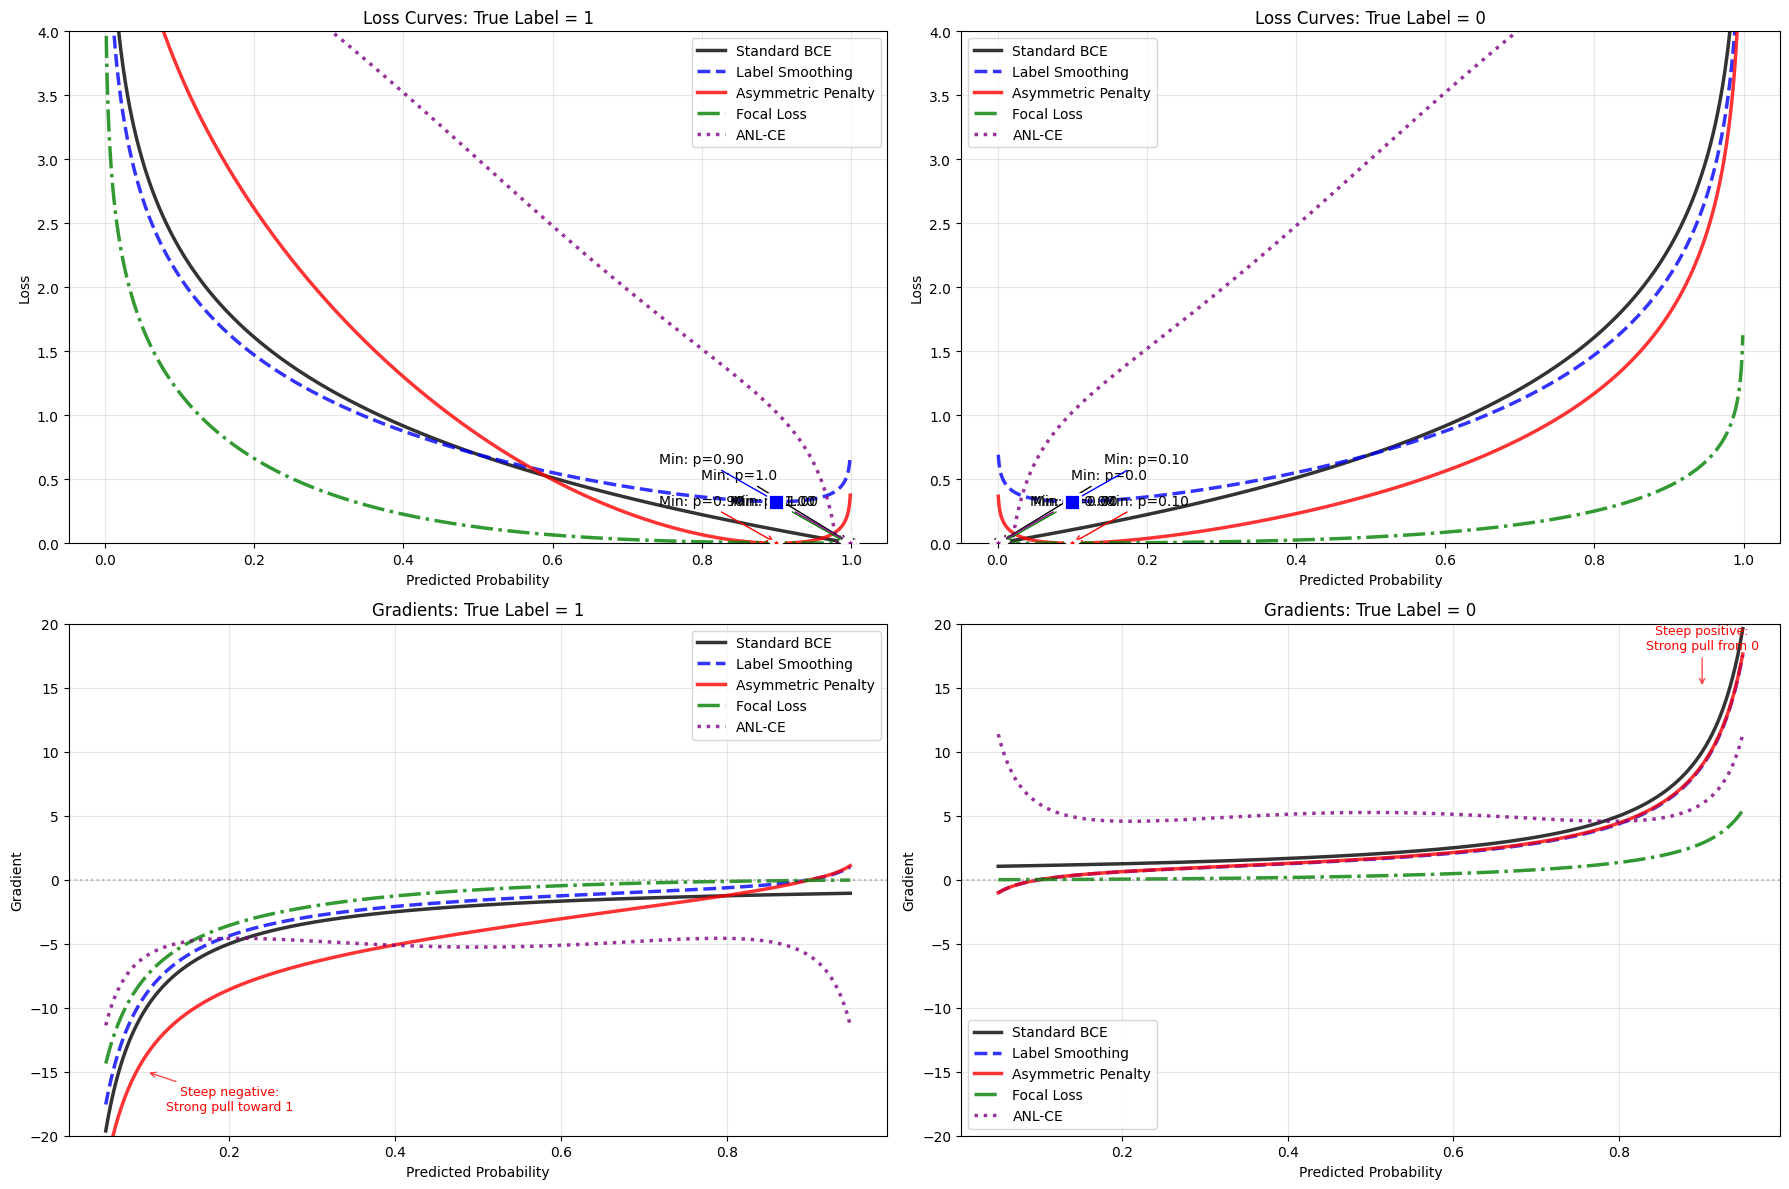

ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS

PARAMETERS:
  Label smoothing (ε): 0.1
  Asymmetry strength_pos: 3.0
  Asymmetry strength_neg: 0.05
  Focal gamma: 2.0
  Focal alpha: 0.75

MINIMA LOCATIONS:
  True=0:
    Standard BCE: p = 0.001
    Label Smoothing: p = 0.100
    Asymmetric Penalty: p = 0.100
    Focal Loss: p = 0.005
    ANL-CE: p = 0.001
  True=1:
    Standard BCE: p = 0.999
    Label Smoothing: p = 0.900
    Asymmetric Penalty: p = 0.900
    Focal Loss: p = 0.995
    ANL-CE: p = 0.999

KEY CHARACTERISTICS:
✅ Standard BCE: Minima at hard labels (0, 1)
✅ Label Smoothing: Minima at smoothed labels (0.1, 0.9)
✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties
   • Steeper penalty toward opposing class
   • Gentler penalty toward actual class
   • Better regularization properties
✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting
✅ ANL-CE: Combines Normalized CE + Normalized Negative CE
   • NCE normalizes BCE by log probability s

In [9]:

if __name__ == "__main__":
    # Example usage
    print("Asymmetric Penalty Binary Cross-Entropy Loss")
    print("=" * 50)

    # Test with sample data
    y_true = tf.constant([1.0, 0.0, 1.0, 0.0])
    y_pred = tf.constant([0.9, 0.1, 0.7, 0.3])

    print("\nSample Loss Calculations:")
    print(f"Standard BCE: {standard_binary_crossentropy(y_true, y_pred).numpy():.4f}")
    print(f"Label Smoothing BCE: {label_smoothing_binary_crossentropy(y_true, y_pred, 0.10).numpy():.4f}")
    print(f"Asymmetric Penalty BCE: {asymmetric_penalty_binary_crossentropy(y_true, y_pred, 0.10, 3., 1.).numpy():.4f}")
    fl = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, from_logits=False, label_smoothing=0.10,
                                 apply_class_balancing=True)
    print(f"Focal Loss (TF/Keras): {fl(y_true, y_pred).numpy():.4f}")
    print(f"Binary ANL-CE: {binary_active_negative_loss(y_true, y_pred, alpha=3.0, beta=3.0, min_prob=0.02).numpy():.4f}")

    print("\nGenerating comprehensive visualization...")
    plot_loss_comparison(label_smoothing=0.1, asymmetry_strength_pos=3.0, asymmetry_strength_neg=0.05, focal_gamma=2.0,
                         focal_alpha=0.75, anl_alpha=3, anl_beta=3, anl_min_prob=0.02)


LOSS FUNCTIONS COMPARISON ON REAL-WORLD BENCHMARK
Dataset: Breast Cancer Wisconsin (UCI ML Repository)

DATASET: Breast Cancer Wisconsin (Diagnostic)
Samples: 569
Features: 30
Classes: Malignant (0) and Benign (1)
Class distribution: [212 357]

Training set noise injection: 20.0%
  Clean samples: 364
  Noisy samples: 91
  Test set: CLEAN (for unbiased evaluation)

Training: Standard BCE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test AUC: 0.9927
Final Test Accuracy: 0.9211
Final Test F1: 0.9353

Training: Label Smoothing


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test AUC: 0.9907
Final Test Accuracy: 0.9561
Final Test F1: 0.9655

Training: Asymmetric Penalty


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test AUC: 0.9884
Final Test Accuracy: 0.8596
Final Test F1: 0.9000

Training: Focal Loss


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test AUC: 0.9666
Final Test Accuracy: 0.8684
Final Test F1: 0.9057

Training: ANL-CE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test AUC: 0.9944
Final Test Accuracy: 0.9386
Final Test F1: 0.9510


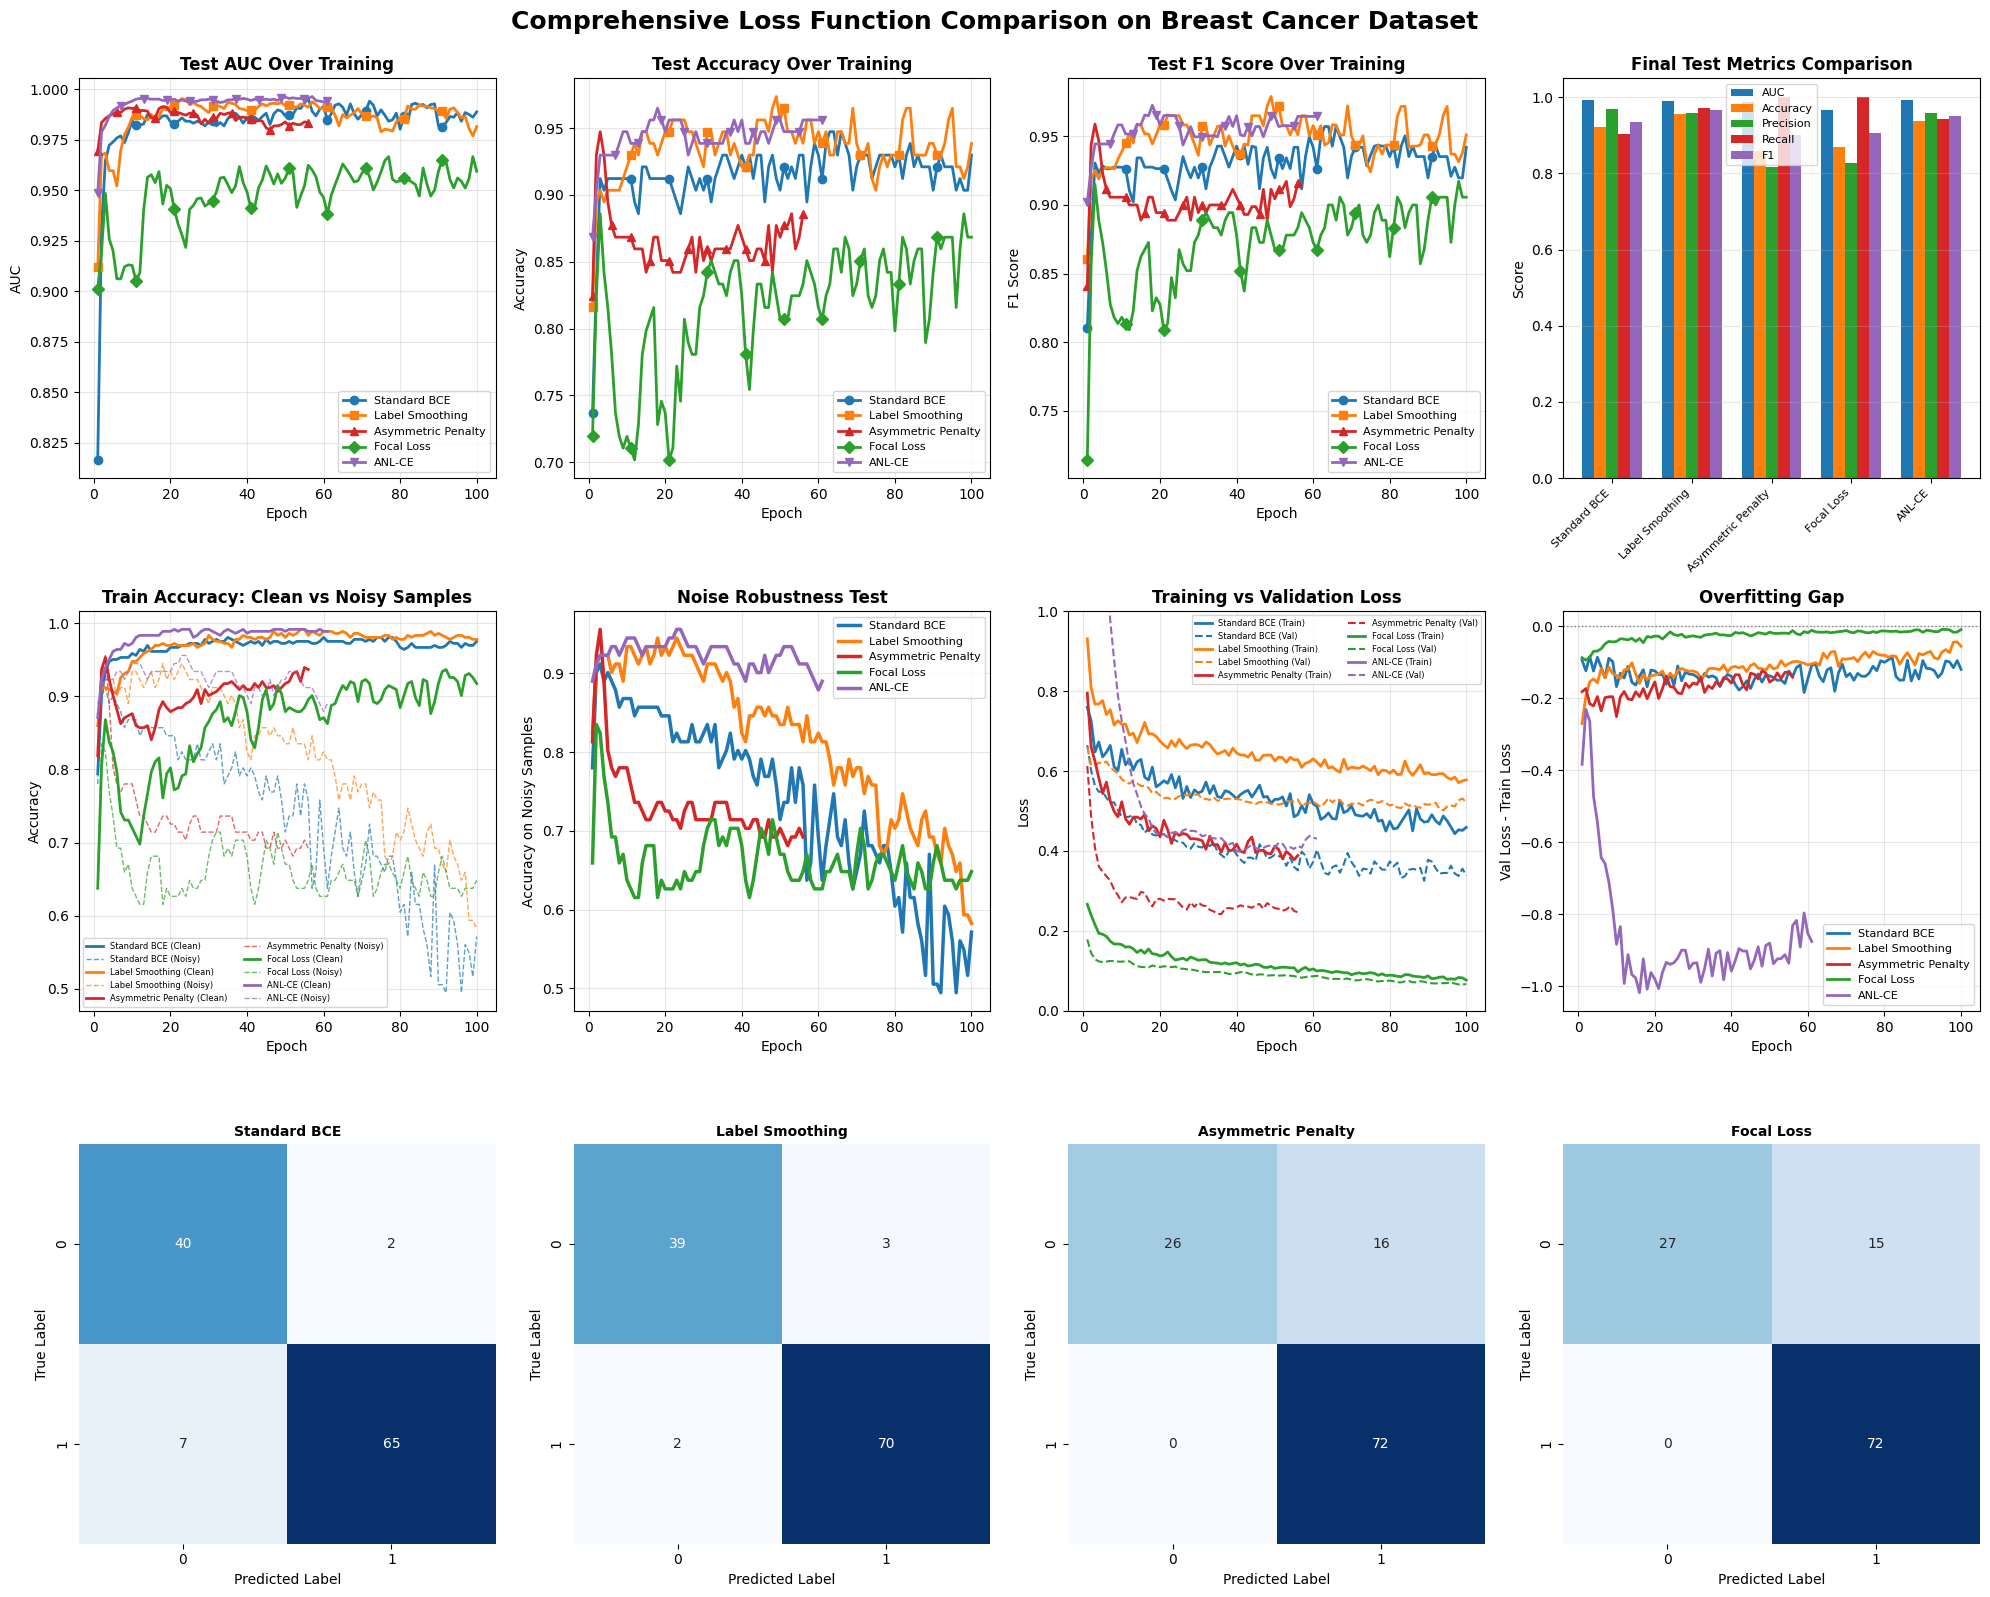


FINAL PERFORMANCE SUMMARY
     Loss Function  Test AUC  Test Acc  Precision   Recall       F1  Acc on Noisy
            ANL-CE  0.994378  0.938596   0.957746 0.944444 0.951049      0.890110
      Standard BCE  0.992725  0.921053   0.970149 0.902778 0.935252      0.571429
   Label Smoothing  0.990741  0.956140   0.958904 0.972222 0.965517      0.582418
Asymmetric Penalty  0.988426  0.859649   0.818182 1.000000 0.900000      0.692308
        Focal Loss  0.966601  0.868421   0.827586 1.000000 0.905660      0.648352

------------------------------------------------------------------------------------------
BEST PERFORMERS:
  🏆 Highest AUC: ANL-CE (0.9944)
  🏆 Highest Accuracy: Label Smoothing (0.9561)
  🏆 Highest F1: Label Smoothing (0.9655)
  🏆 Best Noise Robustness: ANL-CE (0.8901)


✅ Analysis complete!
Key observations:
  • Compare Test AUC/Accuracy to see overall performance
  • Check 'Acc on Noisy' to evaluate noise robustness
  • Lower overfitting gap indicates better generalizatio

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

def load_breast_cancer_with_noise(noise_rate=0.2, random_state=42):
    """
    Load Breast Cancer Wisconsin dataset and inject controlled label noise.

    Returns clean test set for proper evaluation.
    """
    # Load data
    data = load_breast_cancer()
    X, y = data.data, data.target

    print(f"\n{'='*80}")
    print(f"DATASET: Breast Cancer Wisconsin (Diagnostic)")
    print(f"{'='*80}")
    print(f"Samples: {len(y)}")
    print(f"Features: {X.shape[1]}")
    print(f"Classes: Malignant (0) and Benign (1)")
    print(f"Class distribution: {np.bincount(y)}")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train_clean, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=random_state, stratify=y
    )

    # Inject label noise in training set only
    np.random.seed(random_state)
    n_train = len(y_train_clean)
    n_noise = int(n_train * noise_rate)
    noise_indices = np.random.choice(n_train, n_noise, replace=False)

    y_train_noisy = y_train_clean.copy()
    y_train_noisy[noise_indices] = 1 - y_train_noisy[noise_indices]

    # Track noise categories
    noise_mask = np.zeros(n_train, dtype=bool)
    noise_mask[noise_indices] = True

    categories = {
        'clean': ~noise_mask,
        'noisy': noise_mask,
        'clean_positive': (y_train_clean == 1) & (~noise_mask),
        'clean_negative': (y_train_clean == 0) & (~noise_mask),
        'noisy_positive': (y_train_clean == 1) & noise_mask,
        'noisy_negative': (y_train_clean == 0) & noise_mask
    }

    print(f"\nTraining set noise injection: {noise_rate*100:.1f}%")
    print(f"  Clean samples: {np.sum(~noise_mask)}")
    print(f"  Noisy samples: {np.sum(noise_mask)}")
    print(f"  Test set: CLEAN (for unbiased evaluation)")

    return X_train, X_test, y_train_noisy, y_test, y_train_clean, categories


def create_standard_model(input_dim, architecture='standard'):
    """
    Create a standardized neural network architecture for binary classification.

    Architecture options:
    - 'standard': Standard 3-layer network
    - 'deep': Deeper 5-layer network
    - 'regularized': With stronger regularization
    """
    if architecture == 'standard':
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,),
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    elif architecture == 'deep':
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    else:  # regularized
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,),
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(32, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    return model


class ComprehensiveMetricsCallback(tf.keras.callbacks.Callback):
    """Track comprehensive metrics including performance on clean vs noisy samples."""

    def __init__(self, X_train, y_train_clean, categories, X_test, y_test):
        super().__init__()
        self.X_train = X_train
        self.y_train_clean = y_train_clean
        self.categories = categories
        self.X_test = X_test
        self.y_test = y_test

        self.metrics = {
            'test_auc': [], 'test_acc': [], 'test_precision': [], 'test_recall': [], 'test_f1': [],
            'train_acc_clean': [], 'train_acc_noisy': [],
            'train_auc_clean': [], 'train_auc_noisy': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Test set predictions (clean labels)
        y_pred_test = self.model.predict(self.X_test, verbose=0).flatten()
        y_pred_test_binary = (y_pred_test > 0.5).astype(int)

        # Test metrics
        self.metrics['test_auc'].append(roc_auc_score(self.y_test, y_pred_test))
        self.metrics['test_acc'].append(accuracy_score(self.y_test, y_pred_test_binary))
        self.metrics['test_precision'].append(precision_score(self.y_test, y_pred_test_binary, zero_division=0))
        self.metrics['test_recall'].append(recall_score(self.y_test, y_pred_test_binary, zero_division=0))
        self.metrics['test_f1'].append(f1_score(self.y_test, y_pred_test_binary, zero_division=0))

        # Training set predictions (evaluate against clean labels)
        y_pred_train = self.model.predict(self.X_train, verbose=0).flatten()
        y_pred_train_binary = (y_pred_train > 0.5).astype(int)

        # Separate evaluation on clean vs noisy samples
        clean_mask = self.categories['clean']
        noisy_mask = self.categories['noisy']

        self.metrics['train_acc_clean'].append(
            accuracy_score(self.y_train_clean[clean_mask], y_pred_train_binary[clean_mask])
        )
        self.metrics['train_acc_noisy'].append(
            accuracy_score(self.y_train_clean[noisy_mask], y_pred_train_binary[noisy_mask])
        )

        if len(np.unique(self.y_train_clean[clean_mask])) > 1:
            self.metrics['train_auc_clean'].append(
                roc_auc_score(self.y_train_clean[clean_mask], y_pred_train[clean_mask])
            )
        else:
            self.metrics['train_auc_clean'].append(0.5)

        if len(np.unique(self.y_train_clean[noisy_mask])) > 1:
            self.metrics['train_auc_noisy'].append(
                roc_auc_score(self.y_train_clean[noisy_mask], y_pred_train[noisy_mask])
            )
        else:
            self.metrics['train_auc_noisy'].append(0.5)


def train_and_evaluate_losses(X_train, X_test, y_train_noisy, y_test, y_train_clean,
                               categories, epochs=100, model_architecture='standard'):
    """
    Train models with different loss functions and comprehensively evaluate them.
    """

    loss_configs = {
        'Standard BCE': {
            'fn': standard_binary_crossentropy,
            'color': '#1f77b4',
            'marker': 'o'
        },
        'Label Smoothing': {
            'fn': lambda yt, yp: label_smoothing_binary_crossentropy(yt, yp, 0.1),
            'color': '#ff7f0e',
            'marker': 's'
        },
        'Asymmetric Penalty': {
            'fn': lambda yt, yp: asymmetric_penalty_binary_crossentropy(yt, yp, 0.1, 3.0, 0.05),
            'color': '#d62728',
            'marker': '^'
        },
        'Focal Loss': {
            'fn': BinaryFocalCrossentropy(gamma=2.0, alpha=0.75, label_smoothing=0.1,
                                         apply_class_balancing=True),
            'color': '#2ca02c',
            'marker': 'D'
        },
        'ANL-CE': {
            'fn': lambda yt, yp: binary_active_negative_loss(yt, yp, alpha=3.0, beta=3.0, min_prob=0.02),
            'color': '#9467bd',
            'marker': 'v'
        }
    }

    results = {}
    input_dim = X_train.shape[1]

    for loss_name, config in loss_configs.items():
        print(f"\n{'='*60}")
        print(f"Training: {loss_name}")
        print(f"{'='*60}")

        # Create model
        model = create_standard_model(input_dim, architecture=model_architecture)

        # Setup callbacks
        metrics_callback = ComprehensiveMetricsCallback(
            X_train, y_train_clean, categories, X_test, y_test
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        )

        # Compile and train
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=config['fn'],
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train_noisy,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=32,
            callbacks=[metrics_callback, early_stop],
            verbose=0
        )

        # Final evaluation
        y_pred_test = model.predict(X_test, verbose=0).flatten()
        y_pred_test_binary = (y_pred_test > 0.5).astype(int)

        final_metrics = {
            'test_auc': roc_auc_score(y_test, y_pred_test),
            'test_acc': accuracy_score(y_test, y_pred_test_binary),
            'test_precision': precision_score(y_test, y_pred_test_binary, zero_division=0),
            'test_recall': recall_score(y_test, y_pred_test_binary, zero_division=0),
            'test_f1': f1_score(y_test, y_pred_test_binary, zero_division=0),
            'confusion_matrix': confusion_matrix(y_test, y_pred_test_binary)
        }

        print(f"Final Test AUC: {final_metrics['test_auc']:.4f}")
        print(f"Final Test Accuracy: {final_metrics['test_acc']:.4f}")
        print(f"Final Test F1: {final_metrics['test_f1']:.4f}")

        results[loss_name] = {
            'model': model,
            'history': history,
            'metrics_callback': metrics_callback,
            'final_metrics': final_metrics,
            'color': config['color'],
            'marker': config['marker']
        }

    return results


def plot_comprehensive_results(results):
    """Create comprehensive visualization of all results."""

    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Comprehensive Loss Function Comparison on Breast Cancer Dataset',
                 fontsize=18, fontweight='bold', y=0.995)

    # 1. Test AUC over epochs
    ax1 = plt.subplot(3, 4, 1)
    for name, res in results.items():
        epochs_range = range(1, len(res['metrics_callback'].metrics['test_auc']) + 1)
        ax1.plot(epochs_range, res['metrics_callback'].metrics['test_auc'],
                label=name, color=res['color'], linewidth=2, marker=res['marker'],
                markevery=max(1, len(epochs_range)//10))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('AUC')
    ax1.set_title('Test AUC Over Training', fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Test Accuracy over epochs
    ax2 = plt.subplot(3, 4, 2)
    for name, res in results.items():
        epochs_range = range(1, len(res['metrics_callback'].metrics['test_acc']) + 1)
        ax2.plot(epochs_range, res['metrics_callback'].metrics['test_acc'],
                label=name, color=res['color'], linewidth=2, marker=res['marker'],
                markevery=max(1, len(epochs_range)//10))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy Over Training', fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. Test F1 Score over epochs
    ax3 = plt.subplot(3, 4, 3)
    for name, res in results.items():
        epochs_range = range(1, len(res['metrics_callback'].metrics['test_f1']) + 1)
        ax3.plot(epochs_range, res['metrics_callback'].metrics['test_f1'],
                label=name, color=res['color'], linewidth=2, marker=res['marker'],
                markevery=max(1, len(epochs_range)//10))
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('Test F1 Score Over Training', fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    # 4. Final Test Metrics Comparison
    ax4 = plt.subplot(3, 4, 4)
    metrics_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
    x = np.arange(len(results))
    width = 0.15

    for i, metric in enumerate(['test_auc', 'test_acc', 'test_precision', 'test_recall', 'test_f1']):
        values = [res['final_metrics'][metric] for res in results.values()]
        ax4.bar(x + i*width, values, width, label=metrics_names[i])

    ax4.set_ylabel('Score')
    ax4.set_title('Final Test Metrics Comparison', fontweight='bold')
    ax4.set_xticks(x + width * 2)
    ax4.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=8)
    ax4.legend(fontsize=8)
    ax4.grid(True, axis='y', alpha=0.3)

    # 5. Clean vs Noisy Training Accuracy
    ax5 = plt.subplot(3, 4, 5)
    for name, res in results.items():
        epochs_range = range(1, len(res['metrics_callback'].metrics['train_acc_clean']) + 1)
        ax5.plot(epochs_range, res['metrics_callback'].metrics['train_acc_clean'],
                label=f'{name} (Clean)', color=res['color'], linewidth=2, linestyle='-')
        ax5.plot(epochs_range, res['metrics_callback'].metrics['train_acc_noisy'],
                label=f'{name} (Noisy)', color=res['color'], linewidth=1, linestyle='--', alpha=0.7)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Accuracy')
    ax5.set_title('Train Accuracy: Clean vs Noisy Samples', fontweight='bold')
    ax5.legend(fontsize=6, ncol=2)
    ax5.grid(True, alpha=0.3)

    # 6. Noise Robustness (Accuracy on Noisy Samples)
    ax6 = plt.subplot(3, 4, 6)
    for name, res in results.items():
        epochs_range = range(1, len(res['metrics_callback'].metrics['train_acc_noisy']) + 1)
        ax6.plot(epochs_range, res['metrics_callback'].metrics['train_acc_noisy'],
                label=name, color=res['color'], linewidth=2.5)
    ax6.set_xlabel('Epoch')
    ax6.set_ylabel('Accuracy on Noisy Samples')
    ax6.set_title('Noise Robustness Test', fontweight='bold')
    ax6.legend(fontsize=8)
    ax6.grid(True, alpha=0.3)

    # 7-8. Training vs Validation Loss
    ax7 = plt.subplot(3, 4, 7)
    ax8 = plt.subplot(3, 4, 8)

    for name, res in results.items():
        history = res['history']
        epochs_range = range(1, len(history.history['loss']) + 1)

        # Loss curves
        ax7.plot(epochs_range, history.history['loss'],
                label=f'{name} (Train)', color=res['color'], linewidth=2, linestyle='-')
        ax7.plot(epochs_range, history.history['val_loss'],
                label=f'{name} (Val)', color=res['color'], linewidth=1.5, linestyle='--')

        # Overfitting gap
        gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])
        ax8.plot(epochs_range, gap, label=name, color=res['color'], linewidth=2)

    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Loss')
    ax7.set_title('Training vs Validation Loss', fontweight='bold')
    ax7.legend(fontsize=6, ncol=2)
    ax7.grid(True, alpha=0.3)
    ax7.set_ylim(0, 1)

    ax8.set_xlabel('Epoch')
    ax8.set_ylabel('Val Loss - Train Loss')
    ax8.set_title('Overfitting Gap', fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    ax8.grid(True, alpha=0.3)

    # 9-12. Confusion Matrices
    cm_axes = [plt.subplot(3, 4, 9 + i) for i in range(4)]
    loss_names = list(results.keys())[:4]  # First 4 losses

    for ax, loss_name in zip(cm_axes, loss_names):
        cm = results[loss_name]['final_metrics']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{loss_name}', fontweight='bold', fontsize=10)
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


def print_final_summary(results):
    """Print comprehensive summary of results."""

    print(f"\n{'='*90}")
    print("FINAL PERFORMANCE SUMMARY")
    print(f"{'='*90}")

    summary_data = []
    for loss_name, res in results.items():
        metrics = res['final_metrics']
        summary_data.append([
            loss_name,
            metrics['test_auc'],
            metrics['test_acc'],
            metrics['test_precision'],
            metrics['test_recall'],
            metrics['test_f1'],
            res['metrics_callback'].metrics['train_acc_noisy'][-1]
        ])

    df = pd.DataFrame(summary_data, columns=[
        'Loss Function', 'Test AUC', 'Test Acc', 'Precision', 'Recall', 'F1', 'Acc on Noisy'
    ])
    df = df.sort_values('Test AUC', ascending=False)

    print(df.to_string(index=False))
    print(f"\n{'-'*90}")
    print("BEST PERFORMERS:")
    print(f"  🏆 Highest AUC: {df.iloc[0]['Loss Function']} ({df.iloc[0]['Test AUC']:.4f})")
    print(f"  🏆 Highest Accuracy: {df.loc[df['Test Acc'].idxmax(), 'Loss Function']} "
          f"({df['Test Acc'].max():.4f})")
    print(f"  🏆 Highest F1: {df.loc[df['F1'].idxmax(), 'Loss Function']} "
          f"({df['F1'].max():.4f})")
    print(f"  🏆 Best Noise Robustness: {df.loc[df['Acc on Noisy'].idxmax(), 'Loss Function']} "
          f"({df['Acc on Noisy'].max():.4f})")
    print(f"{'='*90}\n")


# Main execution
if __name__ == "__main__":
    print("\n" + "="*80)
    print("LOSS FUNCTIONS COMPARISON ON REAL-WORLD BENCHMARK")
    print("Dataset: Breast Cancer Wisconsin (UCI ML Repository)")
    print("="*80)

    # Load data with controlled noise
    X_train, X_test, y_train_noisy, y_test, y_train_clean, categories = \
        load_breast_cancer_with_noise(noise_rate=0.2, random_state=42)

    # Train and evaluate all loss functions
    results = train_and_evaluate_losses(
        X_train, X_test, y_train_noisy, y_test, y_train_clean, categories,
        epochs=100,
        model_architecture='standard'
    )

    # Visualize results
    plot_comprehensive_results(results)

    # Print summary
    print_final_summary(results)

    print("\n✅ Analysis complete!")
    print("Key observations:")
    print("  • Compare Test AUC/Accuracy to see overall performance")
    print("  • Check 'Acc on Noisy' to evaluate noise robustness")
    print("  • Lower overfitting gap indicates better generalization")
    print("  • Confusion matrices show error patterns")

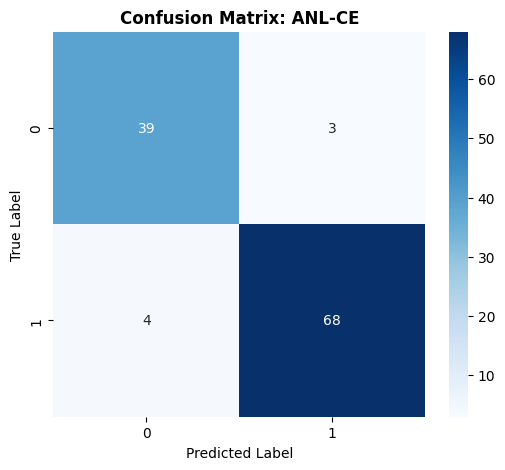

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the confusion matrix for ANL-CE
anl_ce_confusion_matrix = results['ANL-CE']['final_metrics']['confusion_matrix']

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(anl_ce_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: ANL-CE', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()